In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import random
import scipy.io
import pandas as pd
import numpy as np

import matplotlib.pylab as plt 
from sklearn.preprocessing import MinMaxScaler
from pycaret.regression import RegressionExperiment

import pybamm

import gymnasium as gym
from gymnasium import spaces
from gymnasium import Env


from stable_baselines3 import DDPG, PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.noise import NormalActionNoise

In [2]:
def to_df(mat_db):
    """Returns one pd.DataFrame per cycle type"""

    # Features common for every cycle
    cycles_cols = ['type', 'ambient_temperature', 'time']

    # Features monitored during the cycle
    features_cols = {
        'charge': ['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                   'Current_charge', 'Voltage_charge', 'Time'],
        'discharge': ['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                      'Current_charge', 'Voltage_charge', 'Time', 'Capacity'],
        'impedance': ['Sense_current', 'Battery_current', 'Current_ratio',
                      'Battery_impedance', 'Rectified_impedance', 'Re', 'Rct']
    }

    # Define one pd.DataFrame per cycle type
    df = {key: pd.DataFrame() for key in features_cols.keys()}

    # Get every cycle
    cycles = [[row.flat[0] for row in line] for line in mat_db[0][0][0][0]]

    # Get measures for every cycle
    for cycle_id, cycle_data in enumerate(cycles):
        tmp = pd.DataFrame()

        # Data series for every cycle
        features_x_cycle = cycle_data[-1]

        # Get features for the specific cycle type
        features = features_cols[cycle_data[0]]
        
        for feature, data in zip(features, features_x_cycle):
            if len(data[0]) > 1:
                # Correct number of records
                tmp[feature] = data[0]
            else:
                # Single value, so assign it to all rows
                tmp[feature] = data[0][0]
        
        # Add columns common to the cycle measurements
        tmp['id_cycle'] = cycle_id
        for k, col in enumerate(cycles_cols):
            tmp[col] = cycle_data[k]
        
        # Append cycle data to the right pd.DataFrame using pd.concat()
        cycle_type = cycle_data[0]
        df[cycle_type] = pd.concat([df[cycle_type], tmp], ignore_index=True)
    
    return df


def Mat2List(dfs_mat):
    # Example usage
    dfs_B = to_df(dfs_mat)
    df_cycle_charge = dfs_B['charge'] 
    df_cycle_dicharge = dfs_B['discharge'] 

    init_cap = float(df_cycle_dicharge.iloc[0,:]['Capacity'])
    total_result = []   
    X = []
    y = []

    for i in df_cycle_charge['id_cycle'].unique():
        # Filter charge data for the current cycle
        df = df_cycle_charge[df_cycle_charge['id_cycle'] == i]

        # Extract the required columns
        temperature = df['Temperature_measured'].tolist() 
        current = df['Current_measured'].tolist()
        voltage = df['Voltage_measured'].tolist()

        # Find corresponding discharge data
        dis = df_cycle_dicharge[df_cycle_dicharge['id_cycle'] == i + 1]
        
        # Fallback to next cycle if discharge data is empty
        if dis.empty:
            dis = df_cycle_dicharge[df_cycle_dicharge['id_cycle'] == i + 2]    

        # Calculate the label (mean capacity), handle if still empty
        label = dis['Capacity'].mean() /init_cap if not dis.empty else None

        if (label is None) or (label <= 0):
            continue

        else:
            result = [temperature[-1], current[-1],voltage[-1]], float(label)
            total_result.append(result)
            X.append([temperature[-1], current[-1],voltage[-1]])
            y.append(float(label))

    # return total_result
    return X,y

B0005 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0005.mat')
B0006 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0006.mat')
B0007 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0007.mat')
B0018 = scipy.io.loadmat('./DATA/1. BatteryAgingARC-FY08Q4/B0018.mat')

B0005 = B0005['B0005']
B0006 = B0006['B0006']
B0007 = B0007['B0007']
B0018 = B0018['B0018']
# Example usage
dfs_B0005 = to_df(B0005)
dfs_B0006 = to_df(B0006)
dfs_B0007 = to_df(B0007)
dfs_B0018 = to_df(B0018)

# Process data
batt_list = [B0005, B0006, B0007]
df_train = []
X_train = []
Y_trian = []
for batt in batt_list:
    # df_train += Mat2List(batt)
    X, Y= Mat2List(batt)
    X_train += X
    Y_trian += Y

# df_test = Mat2List(B0018)
tiv_df = pd.DataFrame(X_train, columns=['T','I','V'])
label_df = pd.DataFrame(Y_trian, columns=['SOH'])
df_train = pd.concat([tiv_df,label_df], axis= 1)

In [3]:
s = RegressionExperiment()
s.setup(df_train, target = 'SOH', session_id = 123) 
loaded_model = s.load_model('tuned_gbr')

,Description,Value
0,Session id,123
1,Target,SOH
2,Target type,Regression
3,Original data shape,"(507, 4)"
4,Transformed data shape,"(507, 4)"
5,Transformed train set shape,"(354, 4)"
6,Transformed test set shape,"(153, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


Transformation Pipeline and Model Successfully Loaded


In [4]:
# 1209
class DFN(Env):
    def __init__(self, render_mode=None):
        option = {"thermal":"lumped"}
        self.model = pybamm.lithium_ion.SPMe(option)
        self.SoC_desired = 0.8
        self.r_max_temp = 273 + 30
        self.r_max_volt = 4.2
        self.Time_goal = 60
        self.SoC = 0.2
        self.ep_num = 0
        self.charge_rate = 0
        # Define observation space and action space
        self.observation_space = spaces.Box(low=0, high=400, shape=(3,), dtype=np.float32)
        # self.action_space = spaces.Box(dtype=np.float32, low=0, high=3.5, shape=(1,)) 
        # self.action_space = spaces.Box(dtype=np.float32, low=0.1, high=3.5, shape=(1,))
        self.action_space = spaces.Box(dtype=np.float32, low=-0.1, high=0.1, shape=(1,))
        # Initialize PyBaMM model and simulation
        self.parms = pybamm.ParameterValues("Chen2020").copy()      
        
        # use parameter as global 
        self.solution = []
        self.temp = 0
        self.volt = 0
        self.current = 0
        self.stpe_time  = 0
        self.soh_pred_data = []
        self.pred_data_temp= []
        self.pred_data_curr = []
        self.pred_data_volt = []


    def _get_pred_data(self):
        return self.pred_data_temp,self.pred_data_curr,self.pred_data_volt
    
    def pad_to_target_length(self,array, target_length):

        # numpy 배열로 변환 
        array = np.array(array)
        
        # 배열 길이가 목표 길이보다 짧은 경우 처리
        if len(array) < target_length:
            last_value = array[-1]  # 마지막 값 가져오기
            array = np.pad(array, 
                        (0, target_length - len(array)), 
                        'constant', 
                        constant_values=last_value)
            return array

        
    def _get_obs(self):
        #return np.array([self.SoC])
        return np.array([self.SoC, self.volt, self.temp], dtype=np.float32)  
    
    def _get_info(self):
        return {"distance": self.SoC_desired - self.SoC}    

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        option = {"thermal":"lumped"}
        model = pybamm.lithium_ion.SPMe(option)
        self.charge_rate = 1
        self.solution = []

        # Reset SoC and start a new simulation
        self.SoC = 0.2
        experiment = pybamm.Experiment(["Rest for 30 min"])
        sim = pybamm.Simulation(model, experiment=experiment,parameter_values = self.parms)
        step_solution = sim.solve(initial_soc = 0.2)

        self.solution += [step_solution.last_state]
        observation = self._get_obs()
        info = self._get_info()
        self.ep_num +=1
        self.stpe_time  = 0
        print(self.ep_num)
        return observation, info

    def step(self, action):
        option = {"thermal":"lumped"}
        model = pybamm.lithium_ion.SPMe(option)
        reward_last = 0
        if self.SoC >= self.SoC_desired:
            terminated = True
            observation = self._get_obs()
            info = self._get_info()
            self.soh_pred_data = [[self.pred_data_temp[-1],self.pred_data_curr[-1], self.pred_data_volt[-1]]]
            tiv_df_test_1 = pd.DataFrame(self.soh_pred_data, columns=['T','I','V'])
            predictions = s.predict_model(loaded_model, data = tiv_df_test_1)
            soh_pred = predictions['prediction_label']
            soh_pred_num = soh_pred[0]
            if soh_pred_num >= 1:
                soh_pred_num = 1
            reward = soh_pred_num*200

        else:
            terminated = False
        
            self.charge_rate += float(action)

            if float(action)>= 0:
                self.charge_rate = float(min(self.charge_rate,3.5))
            else: 
                self.charge_rate = float(max(self.charge_rate,0))
            # Perform one step in the simulation with the given action (charge rate)
            try:
                experiment = pybamm.Experiment([f"Charge at {self.charge_rate}C for 60 sec or until 4.2 V"])
                sim = pybamm.Simulation(model, experiment=experiment, parameter_values = self.parms)
                step_solution = sim.solve(starting_solution=self.solution[-1].last_state)


                self.solution +=[step_solution]

                # Calculate reward based on various factors
                self.SoC -= (step_solution["Discharge capacity [A.h]"].entries[-1] - step_solution["Discharge capacity [A.h]"].entries[-2]) / self.parms["Nominal cell capacity [A.h]"]
                self.volt = step_solution["Terminal voltage [V]"].entries[-1]
                self.temp = step_solution["X-averaged cell temperature [K]"].entries[-1]
                self.curr = step_solution["Current variable [A]"].entries[-1]

                r_temp = -5 * abs(self.temp - self.r_max_temp) if self.temp > self.r_max_temp else 0
                r_volt = -100 * abs(self.volt - self.r_max_volt) if self.volt > self.r_max_volt else 0
                    #r_fast = -5 * abs(self.stpe_time - self.Time_goal*2) if self.stpe_time > self.Time_goal*2 else -0.1*self.stpe_time
                charge_stan = -(0.6/np.power(self.Time_goal,2))*np.power((self.stpe_time - self.Time_goal),2) + 0.8
                r_fast  = -abs(min(self.SoC - charge_stan, -0.1))
                reward = r_fast + r_temp + r_volt + reward_last

                self.pred_data_temp.append(self.temp-273.15)
                self.pred_data_curr.append(self.curr)
                self.pred_data_volt.append(self.volt)

            except:
                terminated = True
                reward = -1000
            

            
        observation = self._get_obs()
        info = self._get_info()
        print(self.volt,self.temp,self.SoC,reward,"|",action)

        

        return observation, reward, terminated, False, info

    def render(self, mode='human'):
        pass


In [5]:
# It will check your custom environment and output additional warnings if needed
# env  = DFN()
# check_env(env)  

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./logs10/',
                                         name_prefix='rl_model_1212')
env = DFN()
model = PPO('MlpPolicy', env, device = "cuda")
model.learn(total_timesteps=20000, callback=checkpoint_callback)

In [7]:
# env = DFN()
# model = PPO('MlpPolicy', env, device = "cuda")
# model.learn(total_timesteps=(1000))
# model.save("1212batt_1000")

# env = DFN()
# model = PPO('MlpPolicy', env, device = "cuda")
# model.learn(total_timesteps=(10000))
# model.save("1212batt_10000")

# env = DFN()
# model = PPO('MlpPolicy', env, device = "cuda")
# model.learn(total_timesteps=(50000))
# model.save("batt_50000")

# env = DFN()
# model = PPO('MlpPolicy', env, device = "cuda")
# model.learn(total_timesteps=(100000))
# model.save("batt_100000")

In [8]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(df_train, target = 'SOH', session_id = 123) 

loaded_model = s.load_model('tuned_gbr')

,Description,Value
0,Session id,123
1,Target,SOH
2,Target type,Regression
3,Original data shape,"(507, 4)"
4,Transformed data shape,"(507, 4)"
5,Transformed train set shape,"(354, 4)"
6,Transformed test set shape,"(153, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


Transformation Pipeline and Model Successfully Loaded


In [9]:
def run_simulation(model, env):
    """
    Run a simulation using the provided model and environment.

    Parameters:
        model: The trained model to predict actions.
        env: The environment to interact with.

    Returns:
        soc_list: List of SOC (state of charge) values during the simulation.
        volt_list: List of voltage values during the simulation.
        temp_list: List of temperature values during the simulation.
        action_list: List of actions taken during the simulation.
        reward_list: List of cumulative rewards at each step of the simulation.
    """
    vec_env = model.get_env()
    obs = vec_env.reset()

    soc_list = []
    volt_list = []
    temp_list = []
    action_list = []
    reward_list = []
    reward_score = 0
    b = True

    while b:
        action, _states = model.predict(obs)
        observation, reward, terminated, a, info = env.step(action)
        
        reward_score += reward
        soc = observation[0]
        volt = observation[1]
        temp = observation[2]

        action_list.append(action)
        soc_list.append(soc)
        volt_list.append(volt)
        temp_list.append(temp)
        reward_list.append(reward_score)

        if terminated:
            b = False

    return soc_list, volt_list, temp_list, action_list, reward_list


In [ ]:
log_ver = 'logs10'
env = DFN()
model1 = PPO.load(f'./{log_ver}/rl_model_1212_2000_steps',env=env)
soc_list1, volt_list1, temp_list1, action_list1, reward_list1 = run_simulation(model1, env)

env = DFN()
model2 = PPO.load(f'./{log_ver}/rl_model_1212_4000_steps',env=env)
soc_list2, volt_list2, temp_list2, action_list2, reward_list2 = run_simulation(model2, env)

env = DFN()
model3 = PPO.load(f'{log_ver}/rl_model_1212_6000_steps',env=env)
soc_list3, volt_list3, temp_list3, action_list3, reward_list3 = run_simulation(model3, env)

env = DFN()
model4 = PPO.load(f'./{log_ver}/rl_model_1212_8000_steps',env=env)
soc_list4, volt_list4, temp_list4, action_list4, reward_list4 = run_simulation(model4, env)

env = DFN()
model5 = PPO.load(f'./{log_ver}/rl_model_1212_10000_steps',env=env)
soc_list5, volt_list5, temp_list5, action_list5, reward_list5 = run_simulation(model5, env)

# env = DFN()
# model6 = PPO.load(f'./{log_ver}/rl_model_1212_6000_steps',env=env)
# soc_list6, volt_list6, temp_list6, action_list6, reward_list6 = run_simulation(model6, env)

In [22]:

env = DFN()
model5 = PPO.load(f'./{log_ver}/rl_model_1212_10000_steps',env=env)
soc_list5, volt_list5, temp_list5, action_list5, reward_list5 = run_simulation(model5, env)


1
3.7104326372602805 299.36706203032713 0.21833333335786306 -0.1 | [[0.1]]
3.7232179515191954 300.41503416818836 0.2350385401392104 -0.1 | [[-0.09768759]]
3.7613282829786705 301.5677143475579 0.25341041361203187 -0.1 | [[0.1]]
3.7657423063518043 302.4308719396553 0.2701156203933792 -0.1 | [[-0.1]]
3.765602662139474 303.02402688629 0.28515416048325243 -0.22013443145008296 | [[-0.1]]
3.762176130891858 303.3886932414374 0.29852603388165144 -2.0434662071870435 | [[-0.1]]
3.7556835288106507 303.5640017589039 0.3102312405885764 -2.920008794519424 | [[-0.1]]
3.746257949582261 303.58507161440053 0.32026978060402705 -3.0253580720026663 | [[-0.1]]
3.738798910300291 303.50868700215113 0.32903456575953505 -2.6434350107556726 | [[-0.07642529]]
3.764928895920183 303.5471782013822 0.33946601760651707 -2.8358910069111176 | [[0.1]]
3.794443906910049 303.71797536068306 0.35156413614497317 -3.6898768034152796 | [[0.1]]
3.82643820027852 304.0282269793326 0.3653289213749036 -5.241134896663004 | [[0.1]]
3.8

4.131451978401626 303.8204189721977 0.8042946359197156 200 | [[-0.03034252]]


In [11]:
import matplotlib.pyplot as plt

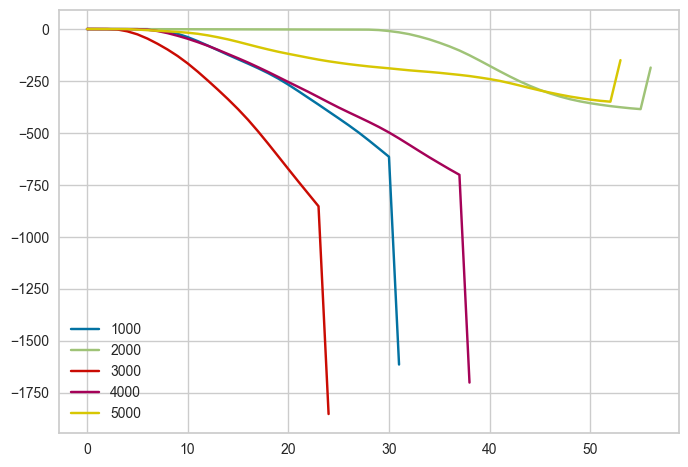

In [23]:

plt.plot(reward_list1, label = '1000')
plt.plot(reward_list2, label = '2000')
plt.plot(reward_list3, label = '3000')
plt.plot(reward_list4, label = '4000')
plt.plot(reward_list5, label = '5000')
# plt.plot(reward_list6, label = '6000')

plt.legend()
plt.show()

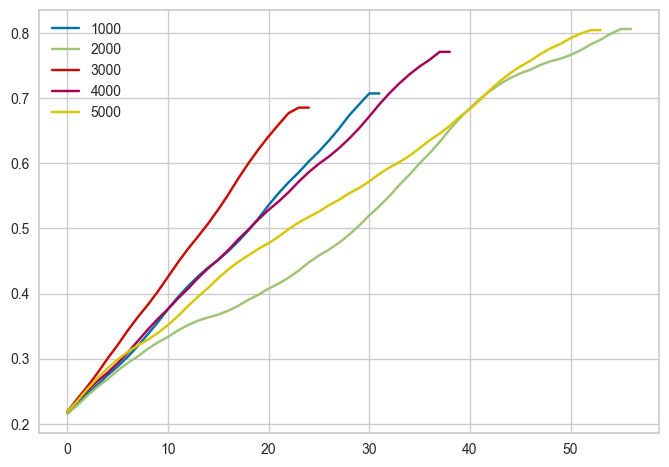

In [24]:

plt.plot(soc_list1, label = '1000')
plt.plot(soc_list2, label = '2000')
plt.plot(soc_list3, label = '3000')
plt.plot(soc_list4, label = '4000')
plt.plot(soc_list5, label = '5000')
# plt.plot(soc_list6, label = '6000')
plt.legend()
plt.show()

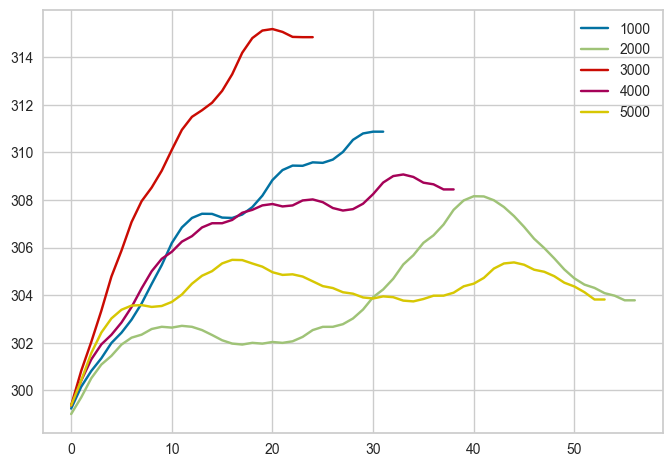

In [25]:

plt.plot(temp_list1, label = '1000')
plt.plot(temp_list2, label = '2000')
plt.plot(temp_list3, label = '3000')
plt.plot(temp_list4, label = '4000')
plt.plot(temp_list5, label = '5000')
# plt.plot(temp_list6, label = '6000')
plt.legend()
plt.show()

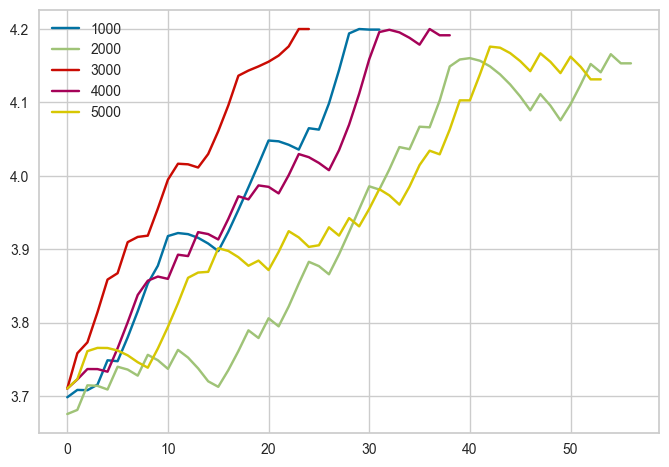

In [26]:

plt.plot(volt_list1, label = '1000')
plt.plot(volt_list2, label = '2000')
plt.plot(volt_list3, label = '3000')
plt.plot(volt_list4, label = '4000')
plt.plot(volt_list5, label = '5000')
# plt.plot(volt_list6, label = '6000')
plt.legend()
plt.show()

In [27]:
action_list_float_1 = []
for i in action_list1:
    action_list_float_1.append(i[0][0])

action_list_float_2 = []
for i in action_list2:
    action_list_float_2.append(i[0][0])

action_list_float_3 = []
for i in action_list3:
    action_list_float_3.append(i[0][0])


action_list_float_4 = []
for i in action_list4:
    action_list_float_4.append(i[0][0])


action_list_float_5 = []
for i in action_list5:
    action_list_float_5.append(i[0][0])

# action_list_float_6 = []
# for i in action_list6:
#     action_list_float_6.append(i[0][0])

In [28]:
cumulative_list_1 = []
current_sum_1 = 1

for value in action_list_float_1:
    current_sum_1 += value
    if current_sum_1 <= 0:
        current_sum_1 = 0
    cumulative_list_1.append(current_sum_1)

cumulative_list_2 = []
current_sum_2 = 1

for value in action_list_float_2:
    current_sum_2 += value
    if current_sum_2 <= 0:
        current_sum_2 = 0
    cumulative_list_2.append(current_sum_2)

cumulative_list_3 = []
current_sum_3 = 1

for value in action_list_float_3:
    current_sum_3 += value
    if current_sum_3 <= 0:
        current_sum_3 = 0
    cumulative_list_3.append(np.float32(current_sum_3))

cumulative_list_4 = []
current_sum_4 = 1
for value in action_list_float_4:
    current_sum_4 += value
    if current_sum_4 <= 0:
        current_sum_4 = 0
    cumulative_list_4.append(current_sum_4)

cumulative_list_5 = []
current_sum_5 = 1

for value in action_list_float_5:
    current_sum_5 += value
    if current_sum_5 <= 0:
        current_sum_5 = 0
    cumulative_list_5.append(np.float32(current_sum_5))

cumulative_list_6 = []
current_sum_6 = 1

# for value in action_list_float_6:
#     current_sum_6 += value
#     if current_sum_6 <= 0:
#         current_sum_6 = 0
#     cumulative_list_6.append(np.float32(current_sum_6))

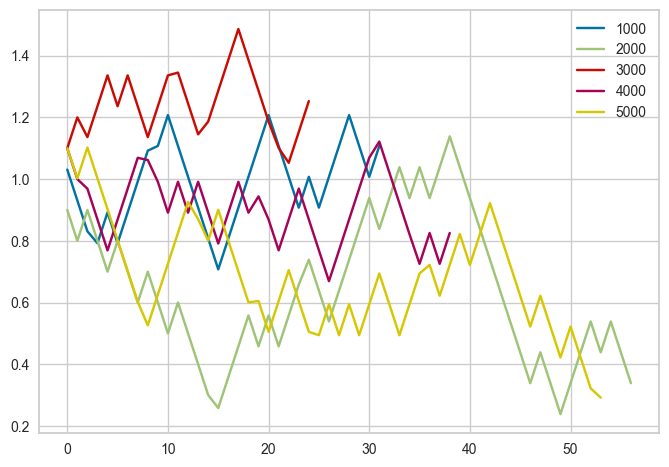

In [29]:
# plt.plot(action_list_float, label = '100')
plt.plot(cumulative_list_1, label = '1000')
plt.plot(cumulative_list_2, label = '2000')
plt.plot(cumulative_list_3, label = '3000')
plt.plot(cumulative_list_4, label = '4000')
plt.plot(cumulative_list_5, label = '5000')
# plt.plot(cumulative_list_6, label = '6000')
plt.legend()
plt.show()